### IMPORTANDO BIBLIOTECAS/MÓDULOS

In [25]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sa
import warnings
import joblib

### CRIANDO SÉRIE TEMPORAL

In [26]:
np.random.seed(0)
data = np.random.normal(3000,1000,200)
serie = pd.DataFrame(data, columns=['Serie'])

### ANALISANDO SÉRIE TEMPORAL

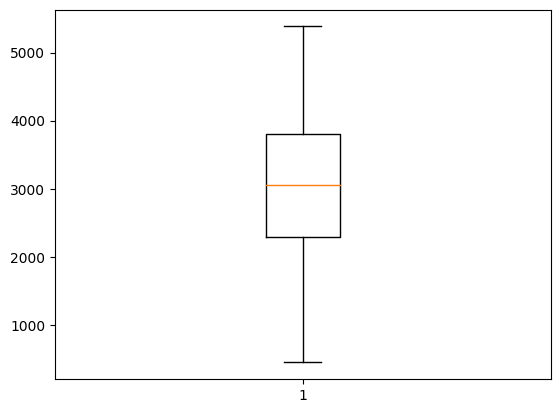

In [27]:
plt.boxplot(serie)
plt.show()

### PLOTANDO SÉRIE

<Axes: >

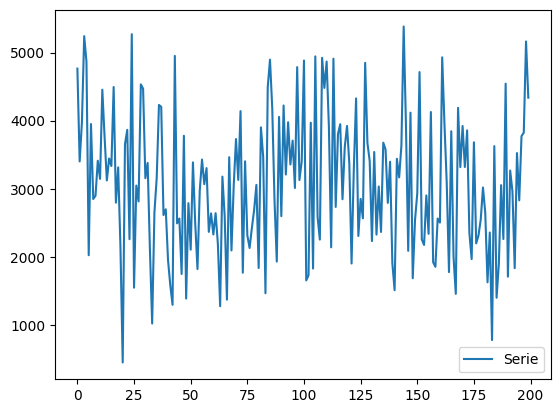

In [28]:
serie.plot()

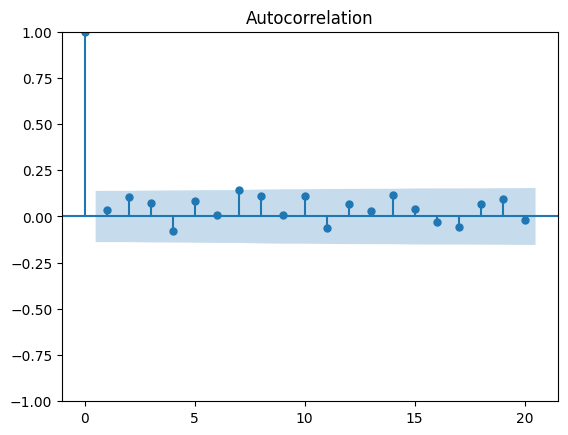

In [29]:
plot_acf(serie, lags=20)
plt.show()

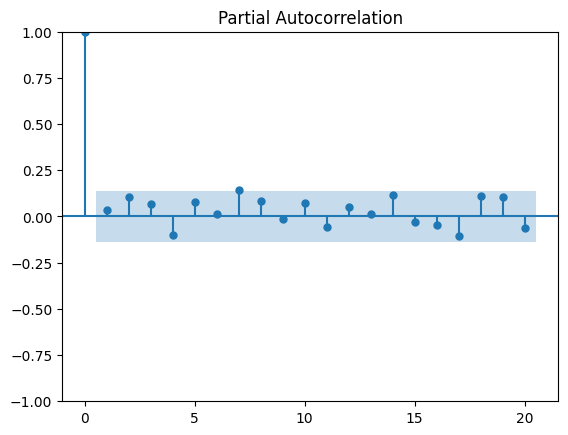

In [30]:
plot_pacf(serie, lags=20)
plt.show()

### DEFININDO BASE TREINO E TESTE

In [31]:
treino = serie['Serie'][:int(len(serie) * 0.8)]
teste = serie['Serie'][int(len(serie) * 0.8):]

print(treino.shape)
print(teste.shape)

(160,)
(40,)


### CONFIGURANDO E TREINANDO OS MODELOS ARIMA E SARIMAX

###### NO MODELO ARIMA, NÃO FOI NECESSÁRIO INCLUIR DIFERENCIAÇÃO, POIS A SÉRIE É ESTACIONÁRIA, TORNANDO O MODELO COMO 'ARMA'

In [32]:
#ARIMA

warnings.filterwarnings('ignore')

def testar(folds):
    order = (folds.suggest_int('p', 1,10),
             folds.suggest_int('d', 0,2),
             folds.suggest_int('q', 1,10)
             )
    model = ARIMA(treino, order=order).fit()
    predictions = model.forecast(steps=int(len(teste)))

    rsme = np.sqrt(mean_squared_error(teste, predictions))
    return rsme

study = optuna.create_study(direction='minimize')
study.optimize(testar, n_trials=40)

best_params = study.best_params
modelo = ARIMA(treino, order=(best_params['p'],best_params['d'],best_params['q'])).fit()

[I 2024-01-31 14:55:28,271] A new study created in memory with name: no-name-85288e29-610a-49d1-a0d0-806d70892715
[I 2024-01-31 14:55:28,900] Trial 0 finished with value: 1031.3363996824805 and parameters: {'p': 10, 'd': 0, 'q': 4}. Best is trial 0 with value: 1031.3363996824805.
[I 2024-01-31 14:55:29,224] Trial 1 finished with value: 1031.1600799433452 and parameters: {'p': 4, 'd': 0, 'q': 3}. Best is trial 1 with value: 1031.1600799433452.
[I 2024-01-31 14:55:29,922] Trial 2 finished with value: 1093.4780698630532 and parameters: {'p': 6, 'd': 0, 'q': 8}. Best is trial 1 with value: 1031.1600799433452.
[I 2024-01-31 14:55:30,415] Trial 3 finished with value: 1059.3142943725643 and parameters: {'p': 8, 'd': 0, 'q': 3}. Best is trial 1 with value: 1031.1600799433452.
[I 2024-01-31 14:55:30,986] Trial 4 finished with value: 1063.0734814696834 and parameters: {'p': 5, 'd': 0, 'q': 7}. Best is trial 1 with value: 1031.1600799433452.
[I 2024-01-31 14:55:31,276] Trial 5 finished with value

In [33]:
#SARIMAX

def testar_sa(folds):
    order = (
            folds.suggest_int('p', 1,10),
            folds.suggest_int('d', 0,2),
            folds.suggest_int('q', 1,10)
             )
    seasonal_order = (
            folds.suggest_int('P', 1,10),
            folds.suggest_int('D', 0,2),
            folds.suggest_int('Q', 1,10),
            folds.suggest_int('m', 12,20)
            )
    model = sa.tsa.SARIMAX(treino, order=order, seasonal_order=seasonal_order).fit()
    predictions = model.forecast(steps=int(len(teste)))

    rsme = np.sqrt(mean_squared_error(teste, predictions))
    return rsme

study_sa = optuna.create_study(direction='minimize')
study_sa.optimize(testar_sa, n_trials=5)

best_params = study_sa.best_params
modelo_sa = sa.tsa.SARIMAX(treino, order=(best_params['p'],best_params['d'],best_params['q']), 
                           seasonal_order=(best_params['P'],best_params['D'],best_params['Q'],best_params['m'])).fit()

[I 2024-01-31 14:55:43,748] A new study created in memory with name: no-name-977e6bf3-50c0-48bd-b940-0b5c366ac88e
[I 2024-01-31 14:57:08,040] Trial 0 finished with value: 1034.3328273454315 and parameters: {'p': 2, 'd': 1, 'q': 6, 'P': 7, 'D': 1, 'Q': 1, 'm': 14}. Best is trial 0 with value: 1034.3328273454315.
[I 2024-01-31 14:58:46,646] Trial 1 finished with value: 1817.197043109778 and parameters: {'p': 3, 'd': 0, 'q': 3, 'P': 8, 'D': 2, 'Q': 4, 'm': 12}. Best is trial 0 with value: 1034.3328273454315.
[I 2024-01-31 14:59:24,246] Trial 2 finished with value: 1129.8168486009426 and parameters: {'p': 3, 'd': 1, 'q': 3, 'P': 5, 'D': 1, 'Q': 4, 'm': 13}. Best is trial 0 with value: 1034.3328273454315.
[I 2024-01-31 15:02:48,227] Trial 3 finished with value: 989.5514036155554 and parameters: {'p': 7, 'd': 1, 'q': 1, 'P': 10, 'D': 0, 'Q': 3, 'm': 17}. Best is trial 3 with value: 989.5514036155554.
[I 2024-01-31 15:05:01,865] Trial 4 finished with value: 1165.4684116520634 and parameters: 

### AVALIANDO TREINAMENTO DOS MODELOS ARIMA E SARIMAX

In [34]:
residuals = pd.DataFrame(modelo.resid)
residuals_sa = pd.DataFrame(modelo_sa.resid)

In [35]:
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                  Serie   No. Observations:                  160
Model:                 ARIMA(2, 0, 8)   Log Likelihood               -1328.835
Date:                Wed, 31 Jan 2024   AIC                           2681.671
Time:                        15:08:25   BIC                           2718.573
Sample:                             0   HQIC                          2696.655
                                - 160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3103.6317    200.354     15.491      0.000    2710.944    3496.319
ar.L1          0.1378      0.218      0.634      0.526      -0.289       0.564
ar.L2          0.7794      0.212      3.682      0.0

In [36]:
print(modelo_sa.summary())

                                          SARIMAX Results                                          
Dep. Variable:                                       Serie   No. Observations:                  160
Model:             SARIMAX(7, 1, 1)x(10, 0, [1, 2, 3], 17)   Log Likelihood               -1319.002
Date:                                     Wed, 31 Jan 2024   AIC                           2682.004
Time:                                             15:08:25   BIC                           2749.520
Sample:                                                  0   HQIC                          2709.422
                                                     - 160                                         
Covariance Type:                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1696      0.150     -1.13

<Axes: ylabel='Density'>

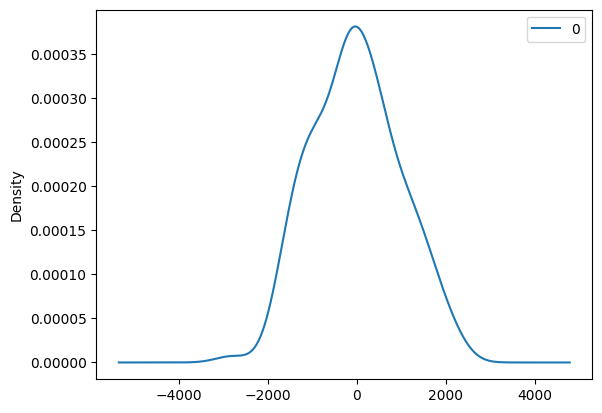

In [37]:
residuals.plot(kind='kde')

<Axes: ylabel='Density'>

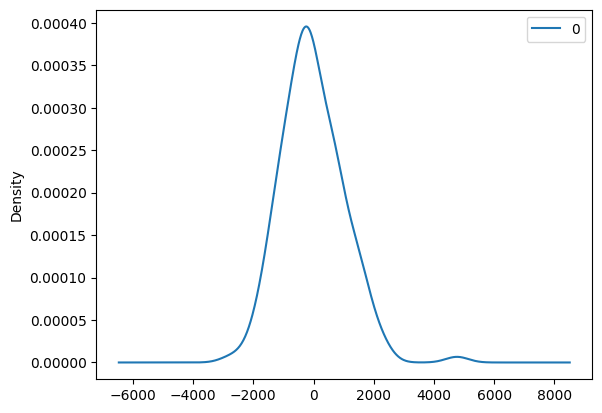

In [38]:
residuals_sa.plot(kind='kde')

### REALIZANDO PREVISÕES E COMPARANDO COM A BASE DE TESTE

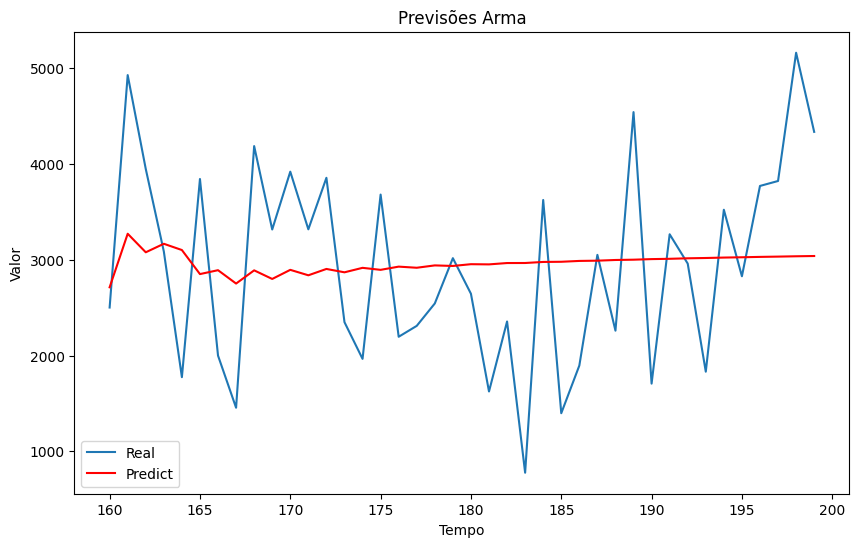

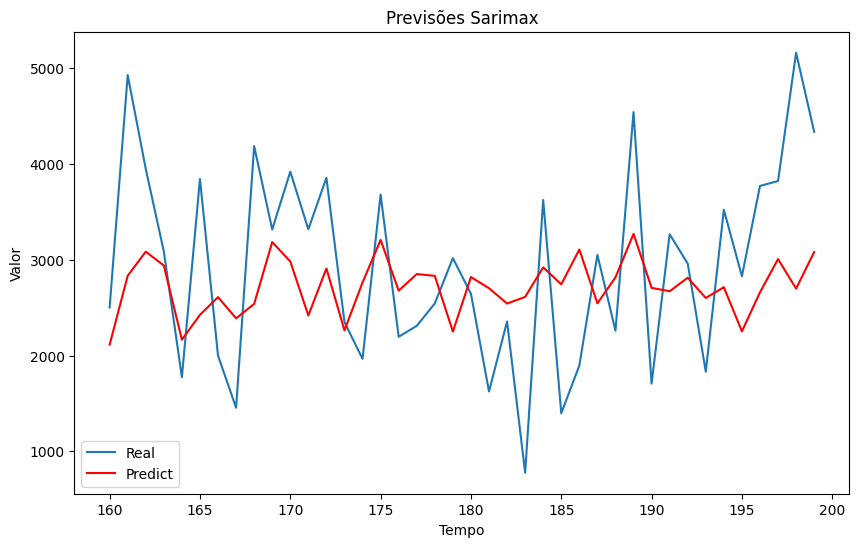

In [39]:
n_forecast = len(teste)
forecast = modelo.forecast(steps=n_forecast)
forcast_sa = modelo_sa.forecast(steps=n_forecast)

predicts = [forecast,forcast_sa]

plt.figure(figsize=(10, 6))
plt.plot(teste)
plt.plot(forecast, color='red')
plt.title('Previsões Arma')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(['Real', 'Predict'])

plt.figure(figsize=(10, 6))
plt.plot(teste)
plt.plot(forcast_sa, color='red')
plt.title('Previsões Sarimax')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(['Real', 'Predict'])

plt.show()

### SALVANDO MODELOS

In [40]:
joblib.dump(modelo,'arima.pkl')
joblib.dump(modelo_sa,'sarimax.pkl')

['sarimax.pkl']

### CARREGANDO MODELOS

In [41]:
arima = joblib.load('arima.pkl')
sarima = joblib.load('sarimax.pkl')